# Milestone project skimlit

In [1]:
## comfirm access to the GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-cec00acb-fddb-3d3a-bc11-d719ce6283ad)


## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os

filenames = [data_dir +filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
## Preprocess data

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples
    

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples),len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14) 

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

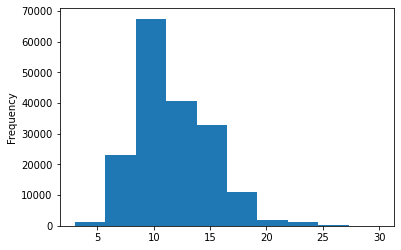

In [13]:
train_df.total_lines.plot.hist()

In [14]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [15]:
#one_hot label

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded  = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [19]:
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ('clf',MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
#Evaluate baseline model on validation dataset
# print(val_labels_encoded[:20])
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [21]:
#make prediction

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-06 21:43:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-06 21:43:01 (61.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
model_0_results = calculate_results(val_labels_encoded,baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [25]:
## Prepare sequences

import numpy as np
from tensorflow.keras import layers
import tensorflow as tf

In [26]:
from tensorflow.keras.layers import TextVectorization

In [27]:
text_vectorizer = TextVectorization(
    max_tokens=68000,
    output_mode="int",
    output_sequence_length=55
)
text_vectorizer.adapt(train_sentences)

In [28]:
import random
random_index = random.randint(0,len(train_sentences)-1)
token = text_vectorizer([train_sentences[random_index]])
token.shape

TensorShape([1, 55])

In [29]:
embedding = layers.Embedding(68000, 128,input_length=55,mask_zero=True)

In [30]:
test = embedding(token)
test.shape

TensorShape([1, 55, 128])

## Create datasets

In [32]:
#Creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [33]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [34]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64,5,activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="conv1d_model")

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [35]:
model_1.summary()

Model: "conv1d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                

In [36]:
model_1_history = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=len(train_dataset),
                              validation_data=val_dataset,
                              validation_steps=len(val_dataset))

Epoch 1/5
5627/5627 [==============================] - 44s 7ms/step - loss: 0.6276 - accuracy: 0.7706 - val_loss: 0.5346 - val_accuracy: 0.8082
Epoch 2/5
5627/5627 [==============================] - 41s 7ms/step - loss: 0.4526 - accuracy: 0.8411 - val_loss: 0.5307 - val_accuracy: 0.8120
Epoch 3/5
5627/5627 [==============================] - 41s 7ms/step - loss: 0.3681 - accuracy: 0.8732 - val_loss: 0.5684 - val_accuracy: 0.8058
Epoch 4/5
5627/5627 [==============================] - 41s 7ms/step - loss: 0.2999 - accuracy: 0.9001 - val_loss: 0.6310 - val_accuracy: 0.7974
Epoch 5/5
5627/5627 [==============================] - 41s 7ms/step - loss: 0.2433 - accuracy: 0.9211 - val_loss: 0.7159 - val_accuracy: 0.7913


In [37]:
 model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7159 - accuracy: 0.7913


[0.7159155011177063, 0.7912749648094177]

In [38]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[1]

array([0.5628864 , 0.08392541, 0.00272573, 0.31817102, 0.03229145],
      dtype=float32)

In [39]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [40]:
model_1_results = calculate_results(val_labels_encoded,model_1_preds)
model_1_results

{'accuracy': 79.12749900701708,
 'f1': 0.7889730836591248,
 'precision': 0.7887790406853726,
 'recall': 0.7912749900701708}

## Model 2 feeature extraction with pre-trained embeddings

In [41]:
import tensorflow_hub as hub

pre_trained_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False)

In [42]:
inputs = layers.Input(shape=(),name="input_layer",dtype=tf.string)
x = pre_trained_embed(inputs)
x = layers.Dense(128,activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2")

model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [43]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [44]:
model_2_history = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=len(train_dataset),
                              validation_data=val_dataset,
                              validation_steps=len(val_dataset))

Epoch 1/5
5627/5627 [==============================] - 92s 16ms/step - loss: 0.7313 - accuracy: 0.7209 - val_loss: 0.6584 - val_accuracy: 0.7488
Epoch 2/5
5627/5627 [==============================] - 89s 16ms/step - loss: 0.6376 - accuracy: 0.7586 - val_loss: 0.6238 - val_accuracy: 0.7619
Epoch 3/5
5627/5627 [==============================] - 88s 16ms/step - loss: 0.6030 - accuracy: 0.7723 - val_loss: 0.6071 - val_accuracy: 0.7702
Epoch 4/5
5627/5627 [==============================] - 87s 16ms/step - loss: 0.5799 - accuracy: 0.7813 - val_loss: 0.5989 - val_accuracy: 0.7731
Epoch 5/5
5627/5627 [==============================] - 89s 16ms/step - loss: 0.5625 - accuracy: 0.7878 - val_loss: 0.5960 - val_accuracy: 0.7742


In [45]:
model_2_pred_preds = model_2.predict(val_dataset)
model_2_pred_preds[:10]

array([[6.8497145e-01, 2.0233904e-01, 5.2494193e-05, 1.1168248e-01,
        9.5447083e-04],
       [5.2998084e-01, 3.1943077e-01, 1.2517170e-03, 1.4837487e-01,
        9.6175191e-04],
       [4.8352435e-01, 1.3759684e-02, 1.3741571e-02, 4.7443360e-01,
        1.4540928e-02],
       [4.6254215e-03, 3.7027113e-02, 8.1808972e-01, 5.6680362e-03,
        1.3458970e-01],
       [2.8970209e-03, 1.6865235e-02, 5.3195822e-01, 3.3163582e-03,
        4.4496313e-01],
       [9.7423777e-05, 1.7672994e-04, 1.0151234e-01, 3.0468604e-05,
        8.9818299e-01],
       [4.3001008e-04, 3.1147854e-04, 5.3768009e-01, 2.9662365e-04,
        4.6128187e-01],
       [1.0616599e-03, 1.6019935e-03, 7.4422961e-01, 1.5911896e-04,
        2.5294757e-01],
       [3.3852825e-04, 2.1363387e-03, 1.1546914e-02, 1.6413936e-04,
        9.8581403e-01],
       [7.1814753e-02, 8.0767530e-01, 1.8735213e-02, 2.3078181e-02,
        7.8696474e-02]], dtype=float32)

In [46]:
model_2_preds = model_2_pred_preds.argmax(axis=1)
model_2_preds[:10]

array([0, 0, 0, 2, 2, 4, 2, 2, 4, 1])

In [47]:
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 77.41625844035482,
 'f1': 0.7704655646903977,
 'precision': 0.7725312340219193,
 'recall': 0.7741625844035482}

## Model 3: COnv1D with character embeddings

In [48]:
##Create character level tokenizer
def split_char(text):
  return " ".join(list(text))

In [49]:
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars = [split_char(sentence) for sentence in val_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]
train_chars[:5],val_chars[:5],test_chars[:5]

(['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
  'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
  'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s  

In [50]:
import string

alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
# Create char-level  token vectorizer instance

NUM_CHAR_TOKENS = len(alphabets) + 2 
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=290,
    name="char_vectorizer"
)

In [52]:
char_vectorizer.adapt(train_chars)

In [53]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab),char_vocab[:5],char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [54]:
random_index = random.randint(0,len(train_chars))
random_sentence = train_chars[random_index]
char_token=char_vectorizer([random_sentence])

In [55]:
# Creating a character level embedings

char_embed = layers.Embedding(input_dim=len(char_vocab),output_dim=25,mask_zero=True,name="char_embed")
char_embed(char_token).shape

TensorShape([1, 290, 25])

In [56]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64,5,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3")

model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [57]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [58]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).prefetch(tf.data.AUTOTUNE).batch(32)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).prefetch(tf.data.AUTOTUNE).batch(32)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).prefetch(tf.data.AUTOTUNE).batch(32)
train_char_dataset

<BatchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [59]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=5,
                              validation_data=val_char_dataset,
                              steps_per_epoch=len(train_char_dataset),
                              validation_steps=len(val_char_dataset))

Epoch 1/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.9063 - accuracy: 0.6436 - val_loss: 0.7844 - val_accuracy: 0.6969
Epoch 2/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.7519 - accuracy: 0.7130 - val_loss: 0.7379 - val_accuracy: 0.7177
Epoch 3/5
5627/5627 [==============================] - 37s 6ms/step - loss: 0.7184 - accuracy: 0.7283 - val_loss: 0.7170 - val_accuracy: 0.7267
Epoch 4/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.7000 - accuracy: 0.7359 - val_loss: 0.7079 - val_accuracy: 0.7323
Epoch 5/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.6881 - accuracy: 0.7408 - val_loss: 0.7000 - val_accuracy: 0.7363


In [60]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

array([[5.4144335e-01, 2.5716612e-01, 4.8557933e-02, 1.4123845e-01,
        1.1594185e-02],
       [1.7261118e-01, 7.1688372e-01, 1.9825476e-03, 9.4809413e-02,
        1.3713140e-02],
       [2.0031416e-01, 1.1673917e-01, 3.7831414e-02, 6.3856691e-01,
        6.5483032e-03],
       [6.3922501e-04, 4.4025821e-03, 9.4878137e-01, 9.7165012e-04,
        4.5205090e-02],
       [9.3831703e-02, 1.5835904e-01, 4.2181644e-01, 3.9249036e-02,
        2.8674385e-01],
       [6.0231538e-05, 2.1580729e-04, 1.2827578e-01, 4.4735400e-05,
        8.7140346e-01],
       [8.9760782e-05, 4.7368396e-04, 2.4309954e-01, 2.9630779e-05,
        7.5630736e-01],
       [5.7142768e-02, 9.6625313e-02, 4.0793979e-01, 5.3926002e-02,
        3.8436607e-01],
       [1.4254637e-04, 3.1178538e-03, 5.6403238e-02, 1.7270415e-04,
        9.4016361e-01],
       [8.0690898e-02, 5.3274024e-01, 1.3980332e-01, 4.3169700e-02,
        2.0359580e-01]], dtype=float32)

In [61]:
model_3_preds = model_3_pred_probs.argmax(axis=1)
model_3_preds[:10]

array([0, 1, 3, 2, 2, 4, 4, 2, 4, 1])

In [62]:
model_3_results = calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 73.63299351251158,
 'f1': 0.7299883519289686,
 'precision': 0.7340137664127685,
 'recall': 0.7363299351251158}

In [63]:
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embedding = pre_trained_embed(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs,token_outputs)


char_inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(5, activation="softmax")(final_dropout)

model_4 = tf.keras.Model([token_model.input,char_model.input],
                         output_layer,
                         name="model_4_token_and_char_embeddings")

In [64]:
 model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_3[0][0]']                
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   [

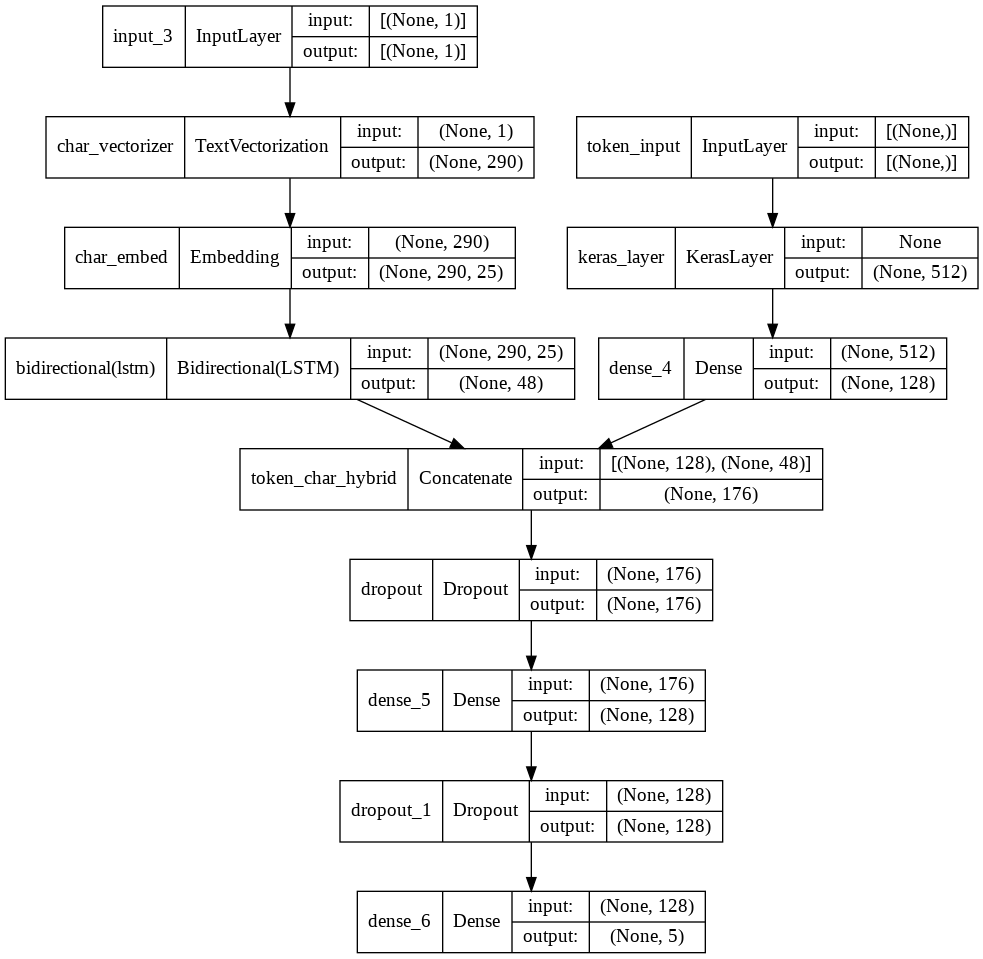

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [66]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [67]:
## Compining tokens

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)).prefetch(tf.data.AUTOTUNE).batch(32)

In [68]:

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels)).prefetch(tf.data.AUTOTUNE).batch(32)

In [69]:
train_char_token_data,val_char_token_data

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>)

In [70]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 45s 63ms/step - loss: 0.9854 - accuracy: 0.6060 - val_loss: 0.7816 - val_accuracy: 0.6988
Epoch 2/5
562/562 [==============================] - 32s 57ms/step - loss: 0.8010 - accuracy: 0.6901 - val_loss: 0.7171 - val_accuracy: 0.7287
Epoch 3/5
562/562 [==============================] - 29s 51ms/step - loss: 0.7735 - accuracy: 0.7083 - val_loss: 0.6870 - val_accuracy: 0.7420
Epoch 4/5
562/562 [==============================] - 34s 60ms/step - loss: 0.7378 - accuracy: 0.7220 - val_loss: 0.6625 - val_accuracy: 0.7523
Epoch 5/5
562/562 [==============================] - 30s 53ms/step - loss: 0.7401 - accuracy: 0.7193 - val_loss: 0.6502 - val_accuracy: 0.7540


In [71]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[10]

array([0.24741805, 0.2756906 , 0.04351412, 0.34778807, 0.08558915],
      dtype=float32)

In [72]:
model_4_preds = model_4_pred_probs.argmax(axis=1)
model_4_preds[:10]

array([0, 0, 3, 2, 2, 2, 2, 4, 4, 1])

In [73]:
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 74.82126307427512,
 'f1': 0.7428814691487552,
 'precision': 0.7448190944485624,
 'recall': 0.7482126307427512}

## Create positional embeddings

In [77]:
# use tensorflow to create one_hot encoding

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [79]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## Building a tribrid embedding model

In [109]:
token_inputs = layers.Input(shape=(),dtype="string")
token_embeddings = pre_trained_embed(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)


char_inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

line_inputs = layers.Input(shape=(15,),dtype=tf.float32)
line_embeds = layers.Dense(32,activation="relu")(line_inputs)
line_model = tf.keras.Model(line_inputs,line_embeds)

total_inputs = layers.Input(shape=(20,),dtype=tf.float32)
total_embeds = layers.Dense(32,activation="relu")(total_inputs)
total_model = tf.keras.Model(total_inputs,total_embeds)


#combine models
combined_embeddings = layers.Concatenate()([token_model.output,char_model.output])
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(.5)(z)
tribrid_embeddings = layers.Concatenate()([line_model.output,total_model.output,z])

output_layer = layers.Dense(5,activation="softmax")(tribrid_embeddings)


model_5 = tf.keras.Model([line_model.input,total_model.input,token_model.input,char_model.input],
                         output_layer)

In [88]:
model_5.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_25[0][0]']               
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_24[0][0]']        

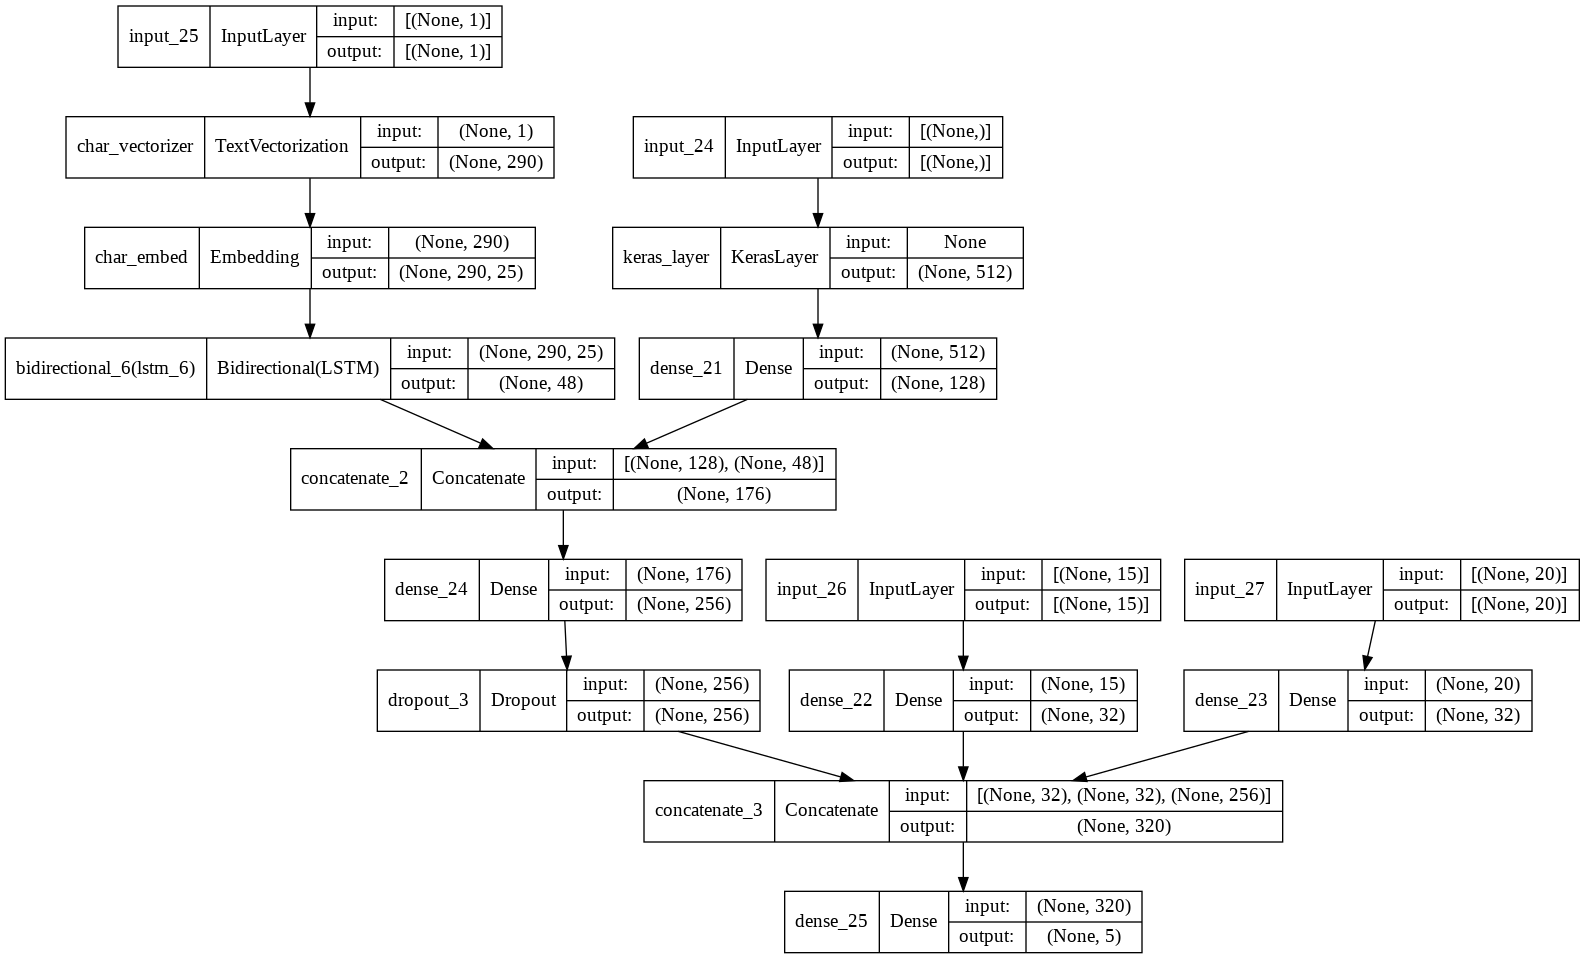

In [89]:
plot_model(model_5,show_shapes=True)

In [110]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [101]:
## Compining tokens

train_char_token_line_total = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_line_total_data,train_char_token_labels)).prefetch(tf.data.AUTOTUNE).batch(32)

In [102]:

val_char_token_line_total_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip((val_char_token_line_total_data,val_char_token_labels)).prefetch(tf.data.AUTOTUNE).batch(32)

In [103]:
train_char_token_dataset

<BatchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [111]:
model_5_history = model_5.fit(train_char_token_dataset ,
                              epochs=5,
                              steps_per_epoch=int(len(val_char_token_dataset)),
                              validation_data=val_char_token_dataset ,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/5
945/945 [==============================] - 88s 83ms/step - loss: 1.0452 - accuracy: 0.7619 - val_loss: 0.9563 - val_accuracy: 0.8186
Epoch 2/5
945/945 [==============================] - 73s 77ms/step - loss: 0.9486 - accuracy: 0.8256 - val_loss: 0.9283 - val_accuracy: 0.8367
Epoch 3/5
945/945 [==============================] - 76s 80ms/step - loss: 0.9374 - accuracy: 0.8357 - val_loss: 0.9176 - val_accuracy: 0.8483
Epoch 4/5
945/945 [==============================] - 78s 82ms/step - loss: 0.9329 - accuracy: 0.8380 - val_loss: 0.9114 - val_accuracy: 0.8489
Epoch 5/5
945/945 [==============================] - 76s 81ms/step - loss: 0.9272 - accuracy: 0.8425 - val_loss: 0.9121 - val_accuracy: 0.8493


In [112]:
model_5_pred_probs = model_5.predict(val_char_token_dataset)
model_5_pred_probs[:10]

array([[0.6460667 , 0.1091259 , 0.01137421, 0.2172985 , 0.01613465],
       [0.66933495, 0.10799732, 0.05607961, 0.15725671, 0.00933135],
       [0.43807134, 0.10487823, 0.16504362, 0.23800094, 0.0540059 ],
       [0.0410983 , 0.07369179, 0.7693973 , 0.03034991, 0.08546267],
       [0.03958222, 0.03392568, 0.83855826, 0.02817116, 0.05976271],
       [0.0104033 , 0.05960624, 0.4003926 , 0.01365653, 0.5159413 ],
       [0.017984  , 0.06111341, 0.33694425, 0.02170265, 0.5622557 ],
       [0.01379057, 0.13148816, 0.30451936, 0.01832591, 0.531876  ],
       [0.02102513, 0.06864844, 0.03537513, 0.0234306 , 0.8515207 ],
       [0.05515809, 0.72283995, 0.0417707 , 0.03031556, 0.14991575]],
      dtype=float32)

In [113]:
model_5_preds = model_5_pred_probs.argmax(axis=1)
model_5_preds[:10]

array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])

In [114]:
model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 84.92982920693764,
 'f1': 0.8445021005751017,
 'precision': 0.8554091155340098,
 'recall': 0.8492982920693765}